In [1]:
import numpy as np
import pandas as pd
np.random.seed(123)

# viz
import matplotlib.pyplot as plt

# notebook settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 1000)

## Sample Prep

In [2]:
samples = pd.read_csv('../data/TCGA/rna-seq_pan/meta/gdc_sample_sheet.2019-12-12.tsv', sep="\t")
# get file type
samples['data'] = [val[1] for i,val in samples['File Name'].str.split(".").items()]
samples.head()

,File ID,File Name,Data Category,Data Type,Project ID,Case ID,Sample ID,Sample Type,data
0,754774dd-77e1-4cf5-b9b5-3afad9f41410,999edb9e-8a45-4115-84d5-fca75dcfa639.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-BRCA,TCGA-E2-A1IG,TCGA-E2-A1IG-01A,Primary Tumor,FPKM
1,8bf102b9-baf7-4749-bcd0-eca25f600722,23393a6a-bfbc-4dec-9ab5-e78a487a095f.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-BRCA,TCGA-EW-A1J5,TCGA-EW-A1J5-01A,Primary Tumor,FPKM
2,5bf7609e-68cb-4ddb-8f05-ee1d4f92cf9b,4a9bb3fd-4e75-4585-82f7-7254889b9838.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-BRCA,TCGA-AR-A1AU,TCGA-AR-A1AU-01A,Primary Tumor,FPKM
3,10a40ceb-080c-4758-97f9-1a262e2639ed,9858d286-1b96-4414-bd09-d73dc6f1c79e.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-LGG,TCGA-DB-A64R,TCGA-DB-A64R-01A,Primary Tumor,FPKM
4,2600ef39-0bdf-4e10-9fdf-e3dbed7b5383,f7182de7-067e-467b-af88-790ad3e63eec.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-LGG,TCGA-P5-A77X,TCGA-P5-A77X-01A,Primary Tumor,FPKM


Samples with RNAseq adjacent normal tissue

In [3]:
samples[samples['Sample Type']=='Solid Tissue Normal']['data'].value_counts()

FPKM    636
Name: data, dtype: int64

In [4]:
samples['project'] = [val[1] for i,val in samples['Project ID'].str.split("-").items()]
samples['project'].value_counts()

BRCA    1206
LUAD     588
UCEC     567
KIRC     554
LUSC     543
LGG      524
PRAD     517
COAD     506
THCA     505
SKCM     469
BLCA     431
LIHC     421
STAD     402
OV       379
KIRP     308
CESC     306
ESCA     171
PAAD     171
GBM      166
TGCT     150
PCPG     133
LAML     123
KICH      81
ACC       75
CHOL      41
SARC      10
DLBC       9
READ       7
MESO       1
Name: project, dtype: int64

In [5]:
# all cases with adjacent normal tissue
cases = samples[samples['Sample Type']=='Solid Tissue Normal']['Case ID']

In [6]:
samples[(samples['Case ID'].isin(cases))]['project'].value_counts()

BRCA    231
KIRC    140
LUAD    124
THCA    106
PRAD    102
LIHC     98
LUSC     94
COAD     83
KIRP     61
STAD     59
KICH     45
UCEC     44
BLCA     40
ESCA     19
CHOL     16
PAAD      8
CESC      6
PCPG      6
READ      2
SKCM      2
Name: project, dtype: int64

In [7]:
# disparity in cases
samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Primary Tumor') 
        & (samples['data']=='FPKM') & (samples['project']=='BRCA')]['Case ID'].nunique()
samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Solid Tissue Normal') 
        & (samples['data']=='FPKM') & (samples['project']=='BRCA')]['Case ID'].nunique()

111

112

In [8]:
# divide, join, subset
case_tumor = samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Primary Tumor') & 
                     (samples['data']=='FPKM') & (samples['project']=='BRCA')]
case_norm = samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Solid Tissue Normal') & 
                    (samples['data']=='FPKM') & (samples['project']=='BRCA')]
cases = case_norm[case_norm['Case ID'].isin(case_tumor['Case ID'])]['Case ID']
cases.shape

(111,)

In [9]:
case_tumor = case_tumor[case_tumor['Case ID'].isin(cases)]
case_norm = case_norm[case_norm['Case ID'].isin(cases)]
cases = pd.concat([case_tumor, case_norm])

In [10]:
case_tumor.shape
case_norm.shape
cases.shape

(116, 10)

(111, 10)

(227, 10)

## Dataset Prep

In [11]:
from sklearn.model_selection import train_test_split

target = 'Sample Type'
cases[target] = cases[target].astype('category')

train, test = train_test_split(cases)
train[target].value_counts()
test[target].value_counts()

Primary Tumor          90
Solid Tissue Normal    80
Name: Sample Type, dtype: int64

Solid Tissue Normal    31
Primary Tumor          26
Name: Sample Type, dtype: int64

In [12]:
train[target].cat.categories

Index(['Primary Tumor', 'Solid Tissue Normal'], dtype='object')

In [13]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable
torch.manual_seed(123)

from trainer import fit
import visualization as vis
import numpy as np
cuda = torch.cuda.is_available()
print("Cuda is available: {}".format(cuda))

classes = {key:val for val,key in enumerate(train[target].cat.categories.values)}
classes

Cuda is available: True


{'Primary Tumor': 0, 'Solid Tissue Normal': 1}

In [14]:
from tcga_datasets import TCGA, SiameseTCGA
root_dir = "../data/TCGA/rna-seq_pan/"
batch_size = 1

train_dataset = TCGA(root_dir, samples=train, train=True, target=target)
test_dataset = TCGA(root_dir, samples=test, train=False, target=target)

kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {'num_workers': 10}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

## Siamese Network

In [20]:
# Step 1 set up dataloader
root_dir = "../data/TCGA"
siamese_train_dataset = SiameseTCGA(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseTCGA(test_dataset)
batch_size = 8
kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from tcga_networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss
from metrics import AccumulatedAccuracyMetric

# Step 2
embedding_net = EmbeddingNet()
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 10
# print training metrics every log_interval * batch_size
log_interval = 30

SiameseNet(
  (embedding_net): EmbeddingNet(
    (fc): Sequential(
      (linear1): Linear(in_features=60483, out_features=2000, bias=True)
      (relu1): PReLU(num_parameters=1)
      (linear2): Linear(in_features=2000, out_features=500, bias=True)
      (relu2): PReLU(num_parameters=1)
      (linear3): Linear(in_features=500, out_features=250, bias=True)
      (relu3): PReLU(num_parameters=1)
      (linear4): Linear(in_features=250, out_features=100, bias=True)
      (relu4): PReLU(num_parameters=1)
      (linear5): Linear(in_features=100, out_features=50, bias=True)
      (relu5): PReLU(num_parameters=1)
      (linear6): Linear(in_features=50, out_features=10, bias=True)
      (relu6): PReLU(num_parameters=1)
      (linear7): Linear(in_features=10, out_features=2, bias=True)
    )
  )
)

In [21]:
train_loss, val_loss = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, 
    n_epochs, cuda, log_interval)

Train: [0/170 (0%)]	Loss: 0.249310
Epoch: 1/10. Train set: Average loss: 342.8445
Epoch: 1/10. Validation set: Average loss: 175.5787
Train: [0/170 (0%)]	Loss: 1758.982422
Epoch: 2/10. Train set: Average loss: 97.6066
Epoch: 2/10. Validation set: Average loss: 12.6505
Train: [0/170 (0%)]	Loss: 3.571903
Epoch: 3/10. Train set: Average loss: 3.9603
Epoch: 3/10. Validation set: Average loss: 7.2180
Train: [0/170 (0%)]	Loss: 1.090388
Epoch: 4/10. Train set: Average loss: 0.9608
Epoch: 4/10. Validation set: Average loss: 4.0968
Train: [0/170 (0%)]	Loss: 0.144620
Epoch: 5/10. Train set: Average loss: 5.3946
Epoch: 5/10. Validation set: Average loss: 6.2441
Train: [0/170 (0%)]	Loss: 27.526621
Epoch: 6/10. Train set: Average loss: 400.1864
Epoch: 6/10. Validation set: Average loss: 19.5219
Train: [0/170 (0%)]	Loss: 5.148102
Epoch: 7/10. Train set: Average loss: 1.5248
Epoch: 7/10. Validation set: Average loss: 2.3443
Train: [0/170 (0%)]	Loss: 0.235626
Epoch: 8/10. Train set: Average loss: 1830

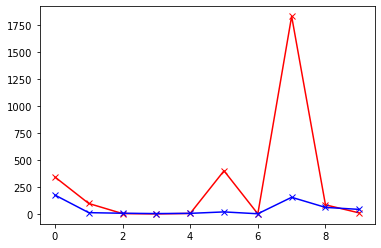

In [22]:
plt.plot(range(0, n_epochs), train_loss, 'rx-')
plt.plot(range(0, n_epochs), val_loss, 'bx-')

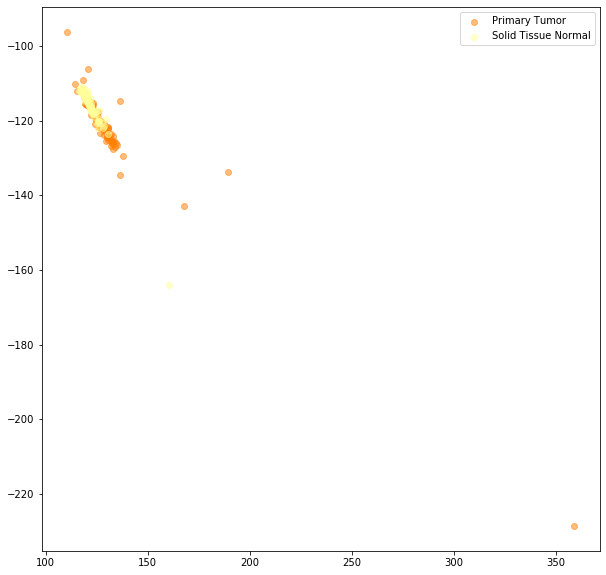

In [23]:
train_embeddings_cl, train_labels_cl = vis.extract_embeddings(train_loader, model)
vis.plot_embeddings(train_embeddings_cl, train_labels_cl, classes.keys())

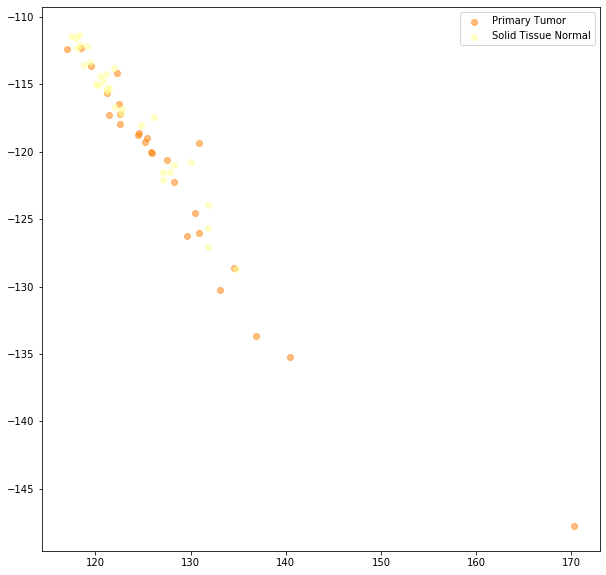

In [24]:
val_embeddings_baseline, val_labels_baseline = vis.extract_embeddings(test_loader, model)
vis.plot_embeddings(val_embeddings_baseline, val_labels_baseline, classes.keys())

## Activation Maximization

In [19]:
import copy
from captum.attr import LayerActivation

In [20]:
tmp_model = copy.deepcopy(model)

In [21]:
tmp_model

SiameseNet(
  (embedding_net): EmbeddingNet(
    (fc): Sequential(
      (linear1): Linear(in_features=60483, out_features=2000, bias=True)
      (relu1): PReLU(num_parameters=1)
      (linear2): Linear(in_features=2000, out_features=500, bias=True)
      (relu2): PReLU(num_parameters=1)
      (linear3): Linear(in_features=500, out_features=250, bias=True)
      (relu3): PReLU(num_parameters=1)
      (linear4): Linear(in_features=250, out_features=100, bias=True)
      (relu4): PReLU(num_parameters=1)
      (linear5): Linear(in_features=100, out_features=50, bias=True)
      (relu5): PReLU(num_parameters=1)
      (linear6): Linear(in_features=50, out_features=10, bias=True)
      (relu6): PReLU(num_parameters=1)
      (linear7): Linear(in_features=10, out_features=2, bias=True)
    )
  )
)

In [22]:
data1, data2, label = tuple(siamese_test_dataset.test_pairs[-1])
data1 = Variable(siamese_test_dataset.test_data[data1], requires_grad=True).cuda().view(1, -1)
data2 = Variable(siamese_test_dataset.test_data[data2], requires_grad=True).cuda().view(1, -1)

### Integrated Gradients; single sample POC

In [23]:
from captum.attr import IntegratedGradients

In [24]:
ig = IntegratedGradients(tmp_model.get_embedding)

In [25]:
data1.shape
data2.shape

torch.Size([1, 60483])

torch.Size([1, 60483])

In [41]:
attr, delta = ig.attribute(data1,target=0, return_convergence_delta=True, n_steps=50)
attr = attr.cpu().detach().numpy()

In [42]:
feat_imp = pd.Series(data=attr[0], index=train_dataset.data.columns)

In [43]:
feat_imp.nlargest(20)

0
ENSG00000087086.12    0.431279
ENSG00000198938.2     0.245747
ENSG00000198804.2     0.167750
ENSG00000198727.2     0.107913
ENSG00000198899.2     0.107248
ENSG00000198712.1     0.098304
ENSG00000198886.2     0.080878
ENSG00000205542.9     0.071370
ENSG00000075624.12    0.070286
ENSG00000117984.11    0.069928
ENSG00000112306.7     0.064462
ENSG00000129538.12    0.062404
ENSG00000034510.5     0.055984
ENSG00000197746.12    0.052530
ENSG00000198888.2     0.051370
ENSG00000184009.8     0.049480
ENSG00000166710.16    0.041028
ENSG00000111341.8     0.040429
ENSG00000156508.16    0.040328
ENSG00000204287.12    0.036875
dtype: float32

### All tumor samples; avg feature attribution

In [44]:
classes
tumor_test_idx = siamese_test_dataset.label_to_indices[classes['Primary Tumor']]
tumor_test = Variable(siamese_test_dataset.test_data[tumor_test_idx], requires_grad=True).cuda()

{'Primary Tumor': 0, 'Solid Tissue Normal': 1}

In [46]:
tumor_test.requires_grad

True

In [60]:
attr, delta = ig.attribute(tumor_test ,target=0, return_convergence_delta=True)
attr = attr.cpu().detach().numpy()

(26, 60483)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c662e5940>]],
      dtype=object)

,Attribution
count,60483.000000
mean,0.000188
std,0.001445
min,-0.018137
25%,0.000000
50%,0.000002
75%,0.000030
max,0.155446


,Attribution
0,
ENSG00000198938.2,0.155446
ENSG00000198804.2,0.117753
ENSG00000087086.12,0.073962
ENSG00000198899.2,0.071012
ENSG00000198712.1,0.069445
ENSG00000198727.2,0.065428
ENSG00000075624.12,0.058782
ENSG00000198886.2,0.058254
ENSG00000184009.8,0.053890


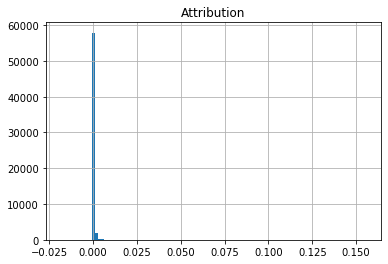

In [97]:
attr.shape
feat_imp = pd.DataFrame(data=attr.mean(axis=0), index=train_dataset.data.columns, columns=['Attribution'])
feat_imp.hist(bins=100)
feat_imp.describe()
feat_imp.nlargest(10, columns='Attribution')

In [98]:
id_map = pd.read_csv("/srv/home/wconnell/keiser/data/uniprot_mapping_ids/map_ensembl_uniprot.csv").set_index(['ENSEMBL_ID'])
id_map.head()

,UNIPROT_ID
ENSEMBL_ID,
ENSG00000000005,TNMD_HUMAN
ENSG00000000419,DPM1_HUMAN
ENSG00000000419,H0Y368_HUMAN
ENSG00000000419,Q5QPJ9_HUMAN
ENSG00000000419,Q5QPK2_HUMAN


In [100]:
feat_imp.index = [ens[0] for ens in feat_imp.index.str.split(".")]
feat_imp.nlargest(50, columns='Attribution')
feat_imp = pd.merge(feat_imp, id_map, left_index=True, right_index=True, how='inner')

,Attribution
ENSG00000198938,0.155446
ENSG00000198804,0.117753
ENSG00000087086,0.073962
ENSG00000198899,0.071012
ENSG00000198712,0.069445
ENSG00000198727,0.065428
ENSG00000075624,0.058782
ENSG00000198886,0.058254
ENSG00000184009,0.053890
ENSG00000112306,0.046174


In [105]:
feat_imp[feat_imp['UNIPROT_ID']=='P53_HUMAN']
feat_imp[feat_imp['UNIPROT_ID']=='BRCA1_HUMAN']

,Attribution,UNIPROT_ID
ENSG00000141510,0.001622,P53_HUMAN


,Attribution,UNIPROT_ID
ENSG00000012048,0.000236,BRCA1_HUMAN
